In [1]:
import numpy as np
import pandas as pd
from Evaluator import ModelEvaluator
import torch
import random
from matplotlib import pylab as plt
from IPython.display import clear_output
import copy

In [2]:
data=pd.read_csv('datasets/malicious_data_generated.csv')
npdata=data.to_numpy()
malData=np.copy(npdata)
print(type(malData[1,:]))
print(malData[:1].shape)

<class 'numpy.ndarray'>
(1, 10)


In [3]:
data.describe()

,-22.0,98.0,-100.0,66.0,-80.0,91.0,63.0,1.0,86.0,100.0
count,999.000000,999.000000,999.000000,999.00000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,-30.213213,-35.531532,-35.878879,-7.05005,-37.938939,17.695696,-36.167167,36.398398,-28.875876,58.014014
std,51.507355,45.365193,45.884891,57.92580,50.487556,54.864394,43.437873,43.651166,52.174966,26.051279
min,-102.000000,-101.000000,-102.000000,-102.00000,-101.000000,-97.000000,-101.000000,-98.000000,-99.000000,0.000000
25%,-71.000000,-70.000000,-71.000000,-55.00000,-79.000000,0.000000,-72.000000,5.000000,-67.000000,40.000000
50%,-37.000000,-45.000000,-42.000000,-14.00000,-49.000000,20.000000,-39.000000,42.000000,-41.000000,60.000000
75%,-5.000000,-13.000000,-15.000000,50.00000,-9.000000,64.000000,-11.000000,73.000000,-9.000000,80.000000
max,100.000000,100.000000,88.000000,102.00000,96.000000,100.000000,92.000000,101.000000,100.000000,102.000000


## control

In [4]:
totalEpochs=1000
totalNumAdversarialData=500
saveValue=totalEpochs-totalNumAdversarialData
if saveValue<=0:
    saveValue=0
totalItemsConv=0

In [5]:
features=['A','B','C','D','F','G','H','I','j','k']
df=pd.DataFrame(columns=features)

In [6]:
class MalwareEnv():
    def __init__(self,totalEpochs):
        # Actions we can take, decrease, increse
        self.action_space = 20  
        # Set start 
        self.state = np.asarray(malData[random.randint(0,498),:])
        #model to evaluate the reward
        self.evaluator=ModelEvaluator()
        #units to move
        self.block=10
        #number of items saved
        self.savedItems=0
        #pointcritic
        self.pointCritic=totalEpochs-totalNumAdversarialData
        #loss
        self.hit=0
        
    def reset(self):
        self.state = np.asarray(malData[random.randint(0,498),:])
        
        
    def step(self, action):
        
        if(action<9):
            self.state[action]+=self.block
        elif(action>=9 and action<19):
            self.state[action-9]-=self.block
            
        
    def reward(self):
        reward=-1
        value=self.state.tolist()
        result=self.evaluator.test(value)
        result=np.array2string(result)
        
        if(result=="['benign']"):
            self.hit+=1
            reward=+10
            self.saveItem()
                 
        return reward    
    
    def saveItem(self):
        
        
        if self.hit>self.pointCritic:
            
            print("saveddddddddddddddddddddddddddddddddddd")
            
            formatier=self.state.reshape(1,-1)[0]
            df.loc[self.savedItems]=formatier
            self.savedItems+=1
            

    def render_np(self):
        return self.state
    

In [7]:


l1 = 10
l2 = 24
l3 = 72
l4 = 20
model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
#device=torch.device("cuda:0" if torch.cuda.is_available else "cpu")
model.cuda()
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
gamma = 0.9
epsilon = 1.0

In [8]:
epochs = copy.copy(totalEpochs)
losses = [] 
env = MalwareEnv(totalEpochs)


for i in range(epochs): 
    env.reset()
    state_ = env.render_np().reshape(1,10) + np.random.rand(1,10)/50.0 
    state1 = torch.from_numpy(state_).float() 
    status = 1 
    while(status == 1): 
        qval = model(state1.cuda()) 
        qval_ = qval.data.cpu().numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,20)
        else:
            action_ = np.argmax(qval_)
        
        env.step(action_) 
        state2_ = env.render_np().reshape(1,10) + np.random.rand(1,10)/50.0
        state2 = torch.from_numpy(state2_).float() 
        reward = env.reward()
        with torch.no_grad():
            newQ = model(state2.reshape(1,10).cuda())
        maxQ = torch.max(newQ) 
        if reward == -1: 
            Y = reward + (gamma * maxQ)
        else:
            Y = reward
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_] 
        loss = loss_fn(X.cuda(), Y.cuda()) 
        print(i, loss.item())
        clear_output(wait=True)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        if reward != -1: 
            status = 0
    if epsilon > 0.1: 
        epsilon -= (1/epochs)

saveddddddddddddddddddddddddddddddddddd
999 17.633241653442383


D:\programas\anaco\envs\latest tf 101021\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [9]:
losses
#clear_output(wait=True)

[231.07058715820312,
 150.3730926513672,
 42.82160568237305,
 183.36924743652344,
 143.72373962402344,
 125.94189453125,
 32.0857048034668,
 0.018464021384716034,
 19.360000610351562,
 2.170933246612549,
 13.08529281616211,
 71.10485076904297,
 2.487159490585327,
 237.64944458007812,
 140.5462646484375,
 30.07541847229004,
 79.16681671142578,
 65.37922668457031,
 338.96551513671875,
 38.539093017578125,
 3.0268192291259766,
 5.996993064880371,
 27.05414390563965,
 15.099676132202148,
 26.242952346801758,
 39.55194854736328,
 0.2954300343990326,
 0.004517979919910431,
 151.32061767578125,
 3.829366683959961,
 48.8536376953125,
 157.03378295898438,
 3.970473527908325,
 3.9448041915893555,
 4.830813884735107,
 12.788671493530273,
 3.17789888381958,
 276.689208984375,
 6.32614278793335,
 137.17306518554688,
 4.478098392486572,
 144.66815185546875,
 6.664428234100342,
 10.777963638305664,
 0.8634448647499084,
 4.752405643463135,
 168.2348175048828,
 180.30690002441406,
 111.89340209960938,


Text(0, 0.5, 'Loss')

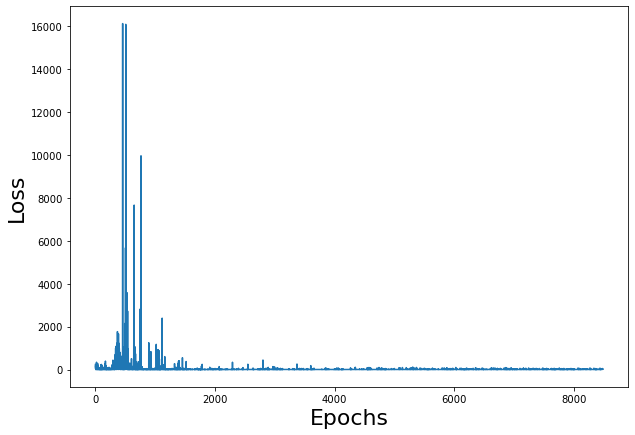

In [10]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [11]:
df

,A,B,C,D,F,G,H,I,j,k
0,-81.0,-32.0,-99.0,-22.0,-121.0,25.0,-59.0,-7.0,7.0,63.0
1,77.0,-62.0,56.0,-45.0,-17.0,-40.0,1.0,4.0,-62.0,69.0
2,40.0,-93.0,-31.0,-37.0,-97.0,45.0,8.0,75.0,-22.0,70.0
3,-45.0,6.0,-102.0,-100.0,-8.0,83.0,-32.0,67.0,-66.0,50.0
4,6.0,-103.0,-66.0,65.0,-75.0,11.0,-90.0,36.0,-49.0,99.0
...,...,...,...,...,...,...,...,...,...,...
495,-30.0,-88.0,-84.0,-27.0,28.0,-63.0,-33.0,79.0,-40.0,26.0
496,-108.0,-16.0,-69.0,-65.0,-54.0,-70.0,-4.0,100.0,9.0,44.0
497,76.0,-64.0,-76.0,-53.0,1.0,89.0,-43.0,91.0,-55.0,67.0
498,-39.0,-1.0,-33.0,91.0,-27.0,53.0,-69.0,88.0,-43.0,18.0


In [12]:
df.to_csv('datasets/Adversarial_data.csv' ,header=False,index=False)

In [13]:
#torch.save(model.state_dict(), 'DRLMalwareModificator.sav')